# Sentiment prediction with self-attention

In [27]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, \
                            recall_score, log_loss
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence
import nltk
from nltk.corpus import stopwords
import re
import string
import time
import csv
import tsensor

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Support code

In [112]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")

def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf") 

## Load glove

In [2]:
glovefile = '/Users/parrt/data/glove/glove.6B.50d.txt'

In [3]:
%time df_glove = pd.read_csv(glovefile, delimiter=" ", header=None, quoting=csv.QUOTE_NONE, na_filter=False)
df_glove.head(2)

CPU times: user 2.49 s, sys: 205 ms, total: 2.69 s
Wall time: 2.73 s


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,the,0.418000,0.24968,-0.41242,0.12170,0.34527,-0.044457,-0.49688,-0.17862,-0.00066,...,-0.298710,-0.15749,-0.34758,-0.045637,-0.44251,0.18785,0.002785,-0.18411,-0.115140,-0.78581
1,",",0.013441,0.23682,-0.16899,0.40951,0.63812,0.477090,-0.42852,-0.55641,-0.36400,...,-0.080262,0.63003,0.32111,-0.467650,0.22786,0.36034,-0.378180,-0.56657,0.044691,0.30392


In [4]:
def load_glove(df_glove):
    itow = [None] + list(df_glove.iloc[:,0].values) # map word index to word; index 0 for unknown word
    wtoi = {w:i for i,w in enumerate(itow)}         # map word to word index; 0 is invalid, 1 is first valid index
    vocab = set(itow)

    glove = df_glove.iloc[:,1:].values              # row glove[i,:] is word vector for word index i
    glove = np.insert(glove, 0, values=0, axis=0)   # make sure row 0 is for invalid / unknown / missing word
    return itow, wtoi, vocab, glove

In [5]:
itow, wtoi, vocab, glove = load_glove(df_glove)
glove[0:4,0:10]

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.42,  0.25, -0.41,  0.12,  0.35, -0.04, -0.5 , -0.18, -0.  , -0.66],
       [ 0.01,  0.24, -0.17,  0.41,  0.64,  0.48, -0.43, -0.56, -0.36, -0.24],
       [ 0.15,  0.3 , -0.17,  0.18,  0.32,  0.34, -0.43, -0.31, -0.45, -0.29]])

In [6]:
d = glove.shape[1] # word vec len
d

50

## Load tweets

In [7]:
df_tweets = pd.read_csv("/Users/parrt/data/airline-tweets.csv")
df_tweets = df_tweets[['text','airline_sentiment']]
df_tweets.columns = ['text','sentiment']
df_tweets['sentiment'] = df_tweets['sentiment'].map({'negative':0, 'neutral':1, 'positive':2})
df_tweets.head()

,text,sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [8]:
def clean(s):
    s = s.lower()
    return ' '.join([w for w in s.split() if w in vocab])

df_tweets['text'] = df_tweets['text'].apply(clean)
df_tweets.head()

,text,sentiment
0,what said.,1
1,plus added commercials to the,2
2,i must mean i need to take another,1
3,really aggressive to blast obnoxious in your f...,0
4,and a really big bad thing about it,0


In [9]:
max_tweet_len = df_tweets['text'].apply(str.split).apply(len).max() # max num words in a tweet
max_tweet_len

31

## Encode tweets as sequence of word indexes

Create matrix where X[i,j] is tweet i and word j within that tweet

In [10]:
def encode_words(df):
    X = torch.zeros(size=[len(df),max_tweet_len], dtype=int)
    for i,tweet in enumerate(df['text'].apply(str.split)):
        word_indexes = [wtoi[w] for w in tweet]
        pad = nn.ConstantPad1d((0,max_tweet_len-len(word_indexes)), 0) # pad on right
        X[i,:] = pad(torch.tensor(word_indexes))
    return X

In [11]:
X = encode_words(df_tweets)
X

tensor([[   103, 258433,      0,  ...,      0,      0,      0],
        [  2259,    296,   7669,  ...,      0,      0,      0],
        [    42,    391,   1703,  ...,      0,      0,      0],
        ...,
        [  3833,    939,    141,  ...,      0,      0,      0],
        [    82,     34,    193,  ...,      0,      0,      0],
        [    54,     34,    653,  ...,      0,      0,      0]])

## Create centroid word vector per tweet

In [47]:
def centroids(X):
    X_encoded = torch.zeros(size=[X.shape[0],d])
    for i,x in enumerate(X):
        wvecs = [glove[wi,:] for wi in x if wi>0]
        nw = len(wvecs)
        if nw==0: # skip any tweets for which we don't have any word vectors
            continue
        wvecs = torch.tensor(wvecs)
#         print(wvecs)
        vsum = torch.sum(wvecs, axis=0)
#         print(vsum)
        centroid = torch.sum(wvecs, axis=0) / nw
#         print(centroid)
        X_encoded[i,:] = centroid
    return X_encoded

In [48]:
X_encoded = centroids(X)
X_encoded

tensor([[-0.1643, -0.5938, -0.2448,  ...,  0.9445, -0.0405,  0.6883],
        [ 0.1134,  0.1977,  0.1945,  ...,  0.2230, -0.1115,  0.2136],
        [ 0.3592,  0.1108,  0.1639,  ...,  0.0512, -0.0813,  0.4020],
        ...,
        [ 0.1618,  0.2027,  0.2104,  ...,  0.1657, -0.1986,  0.3039],
        [ 0.2700,  0.2328,  0.0771,  ...,  0.0269, -0.0474,  0.3363],
        [ 0.3795,  0.0872,  0.2946,  ...,  0.0737, -0.0699,  0.0572]])

In [72]:
nclasses = len(df_tweets['sentiment'].unique())
y = torch.tensor(df_tweets['sentiment'])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2)

In [74]:
n = len(X_train)
print(f"{n:,d} training records, {nclasses} target classes")

11,712 training records, 3 target classes


## Train RF model as baseline

In [75]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
rf.oob_score_

0.7060280054644809

In [76]:
y_proba = rf.predict_proba(X_test)
log_loss(y_test, y_proba)

0.7353782042216309

In [77]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7120901639344263

In [78]:
conf = confusion_matrix(y_test, y_pred)
print(conf)

[[1765   63   22]
 [ 396  160   59]
 [ 246   57  160]]


## Train Vanilla Neural Network

In [80]:
def ctrain(model, X_train, y_train, X_test, y_test, 
           learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        accur = ncorrect.float() / len(y_train)

        y_test_pred = model(X_test)
        loss_test = F.cross_entropy(y_test_pred, y_test)
        y_test_pred = torch.argmax(y_test_pred, axis=1)
        ncorrect = torch.sum(y_test_pred==y_test)
        loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss, loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [169]:
model = nn.Sequential(
    nn.Linear(50, 100),
    nn.ReLU(),
#     nn.Linear(20, 10),
#     nn.ReLU(),
    nn.Linear(100, 3),  # 3 output classes
    nn.Softmax(dim=1)
)

In [170]:
with tsensor.clarify():
    history = ctrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .01, nepochs=1000)

Epoch    0 cross entropy loss  1.0967   test loss  1.0968
Epoch  100 cross entropy loss  0.8160   test loss  0.8258
Epoch  200 cross entropy loss  0.7942   test loss  0.8239
Epoch  300 cross entropy loss  0.7813   test loss  0.8260
Epoch  400 cross entropy loss  0.7728   test loss  0.8264
Epoch  500 cross entropy loss  0.7669   test loss  0.8268
Epoch  600 cross entropy loss  0.7617   test loss  0.8278
Epoch  700 cross entropy loss  0.7581   test loss  0.8271
Epoch  800 cross entropy loss  0.7548   test loss  0.8277
Epoch  900 cross entropy loss  0.7524   test loss  0.8279
Epoch 1000 cross entropy loss  0.7502   test loss  0.8296
LAST       cross entropy loss  0.7502


In [171]:
y_proba = model(X_train)
y_pred = torch.argmax(y_proba, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.805


In [172]:
y_test_proba = model(X_test)
y_test_pred = torch.argmax(y_test_proba, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.715


In [173]:
conf = confusion_matrix(y_test, y_test_pred)
print(conf)

[[1668  121   61]
 [ 346  194   75]
 [ 173   59  231]]


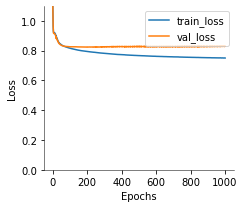

In [174]:
plot_loss(history)

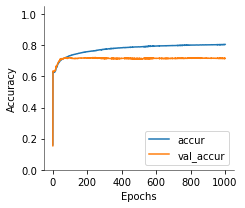

In [175]:
plot_accur(history)

## Train custom word embeddings

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [179]:
n = len(X_train)
print(f"{n:,d} training records, {nclasses} target classes")

11,712 training records, 3 target classes


In [186]:
X_train

tensor([[ 2341, 13954,     5,  ...,     0,     0,     0],
        [ 1293,  5613,     1,  ...,     0,     0,     0],
        [ 1821,   600,    14,  ...,     0,     0,     0],
        ...,
        [57118,    21,   211,  ...,     0,     0,     0],
        [  144,    84,    82,  ...,     0,     0,     0],
        [ 5055,    38, 61315,  ...,     0,     0,     0]])

In [259]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, emb_size=100, nclasses=3):
        super(CBOW, self).__init__()
        self.word_emb = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.linear = nn.Linear(emb_size, nclasses)
        
    def forward(self, x):
        x = self.word_emb(x)
        print(x)
        nw = 1
        x = x.sum(dim=0) / nw
#         print("avg = ", x)
        y_hat = self.linear(x)
#         print("y_hat =", y_hat)
#         y_hat = y_hat.unsqueeze(1)
#         print("y_hat =", y_hat)
        y_hat = F.softmax(y_hat, dim=0)
#         print("softmax(y_hat) =", y_hat.shape, y_hat)
        return y_hat

In [260]:
with tsensor.clarify():
    model = CBOW(len(vocab), emb_size=5, nclasses=nclasses)

In [261]:
def ctrain_emb(model, X_train, y_train, X_test, y_test, 
               learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        print("y_pred =", y_pred.shape, y_pred)
        loss = F.cross_entropy(y_pred, y_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        accur = ncorrect.float() / len(y_train)

        y_test_pred = model(X_test)
        loss_test = F.cross_entropy(y_test_pred, y_test)
        y_test_pred = torch.argmax(y_test_pred, axis=1)
        ncorrect = torch.sum(y_test_pred==y_test)
        loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss, loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

tensor([[[-0.3776,  0.5112, -0.4685, -0.2173, -0.4325],
         [-0.5353, -1.0387, -1.6116,  2.3788, -1.9176],
         [ 0.3490,  0.4177, -1.0080,  0.0900, -0.3951],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[-0.0344,  1.2392, -1.1679,  0.3664, -0.2221],
         [ 0.9226,  0.8736, -0.5068,  0.5104,  0.4232],
         [ 0.0846,  1.2967, -1.9184, -0.8218,  0.6044],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 1.4280,  1.3333,  0.8169,  1.4733,  0.2578],
         [-0.9225, -1.4475, -0.2224, -1.3331, -2.3493],
         [-1.5236, -0.4335,  1.1128, -0.6646, -0.0982],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
  

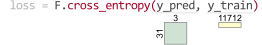

ValueError: Expected input batch_size (31) to match target batch_size (11712).
Cause: F.cross_entropy(y_pred, y_train) tensor arg y_pred w/shape [31, 3], arg y_train w/shape [11712]

In [262]:
with tsensor.clarify():
    history = ctrain_emb(model, X_train, y_train, X_test, y_test,
                         learning_rate = .01, nepochs=1000)

In [171]:
y_proba = model(X_train)
y_pred = torch.argmax(y_proba, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.805


In [172]:
y_test_proba = model(X_test)
y_test_pred = torch.argmax(y_test_proba, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.715


In [173]:
conf = confusion_matrix(y_test, y_test_pred)
print(conf)

[[1668  121   61]
 [ 346  194   75]
 [ 173   59  231]]


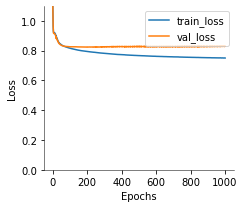

In [174]:
plot_loss(history)

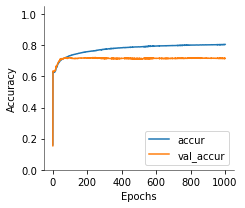

In [175]:
plot_accur(history)

## Junk drawer

In [20]:
max_len = df['text'].apply(str.split).apply(len).max() # max num words in a tweet
max_len

NameError: name 'df' is not defined

In [ ]:
vocab = sorted(set(' '.join(df['text'].values).split()))
vocab[0:20]
wtoi = {w:(i+1) for i,w in enumerate(vocab)}

In [ ]:
y = df['sentiment']
X = torch.zeros(size=[len(df),max_len])
for i,tweet in enumerate(df['text'].apply(str.split)):
    word_indexes = [wtoi[w] for w in tweet]
    pad = nn.ConstantPad1d((0,max_len-len(word_indexes)), 0)
    X[i,:] = pad(torch.tensor(word_indexes))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
n = len(X_train)
embed_sz = 20
nclasses = len(df['sentiment'].unique()) # char output vocab

print(f"{n:,d} training records, {embed_sz} embedding size, {nclasses} target classes")

In [ ]:
class Embedding:
    def __init__(self, input_size, embed_sz):
        self.E = torch.randn(embed_sz, input_size, device=device, dtype=torch.float64, requires_grad=True) # embedding
        self.input_size = input_size
        self.embed_sz = embed_sz
    def parameters(self): return [self.E]
    def __call__(self, x):
        if isinstance(x, int):
            return self.E[:,x].reshape(self.embed_sz, 1)
        # column E[i] is the embedding for char index i. same as multiple E.mm(onehot(i))
        return self.E[:,x]

In [ ]:
class Linear:
    def __init__(self, input_size, output_size):
        self.V = torch.randn(output_size,  input_size, device=device, dtype=torch.float64, requires_grad=True)
        self.by = torch.zeros(output_size, 1,          device=device, dtype=torch.float64, requires_grad=True)
    def parameters(self): return [self.V, self.by]
    def __call__(self, h):
        o = self.V@h + self.by
        o = o.T # make it input_size x output_size
        return o

In [ ]:
torch.nonzero(X_train, as_tuple=True)

In [ ]:
torch.nonzero(X_train)

In [ ]:
x = torch.zeros(size=(*(X_train.shape),embed_sz))
x.shape

In [ ]:
torch.unsqueeze(x,2).shape

In [ ]:

for i,j in zip(*torch.nonzero(X_train, as_tuple=True)):
    print(i,j)

In [ ]:
X_train[1,:]

In [ ]:
E = torch.randn(embed_sz, len(vocab), device=device, dtype=torch.float64, requires_grad=True) # embedding

E[:,32].reshape(embed_sz, 1)